# Churn Analysis Brazilian E-Commerce
by Jessica Syafaq Muthmaina

### Assignment Outcomes:
You should be able to create machine learning models and be able to increase its performance using various methods.

### Instruction:
From the same dataset you used in assignment 3, create a churn probability prediction using various models you have learned in class. What you should do:
- Create several machine learning models
- Compare these models based on performance level, don't forget to increase the performance level with hyperparameter tuning or other methods. 
- Decide which machine learning model the business should use to solve a business problem. 
- Create segmentation from the insights of the model that you choose to help the team make business decisions.

## Import Libraries

In [1]:
import numpy as np 
import pandas as pd 

import time, warnings
import datetime as dt

#Libraries fot visualization 
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

# Standard Machine Learning Model for Comparison 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import r2_score,accuracy_score,classification_report

# Splitting data for training/testing
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans

# Importing libraries for neural network
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.wrappers.scikit_learn import KerasClassifier,KerasRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import xgboost as xgb
from eli5.sklearn import PermutationImportance
import eli5

2022-11-05 01:02:16.832201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#reading datas

import time
start = time.time()
data = pd.read_csv("/Users/syafaqmuth/Desktop/Data Science/Startup Campus/Assignment #3/olist_customers_dataset.csv")
geo_data = pd.read_csv("/Users/syafaqmuth/Desktop/Data Science/Startup Campus/Assignment #3/olist_geolocation_dataset.csv")
order_itemdata = pd.read_csv("/Users/syafaqmuth/Desktop/Data Science/Startup Campus/Assignment #3/olist_order_items_dataset.csv")
pay_data = pd.read_csv("/Users/syafaqmuth/Desktop/Data Science/Startup Campus/Assignment #3/olist_order_payments_dataset.csv")
rev_data = pd.read_csv("/Users/syafaqmuth/Desktop/Data Science/Startup Campus/Assignment #3/olist_order_reviews_dataset.csv")
orders = pd.read_csv("/Users/syafaqmuth/Desktop/Data Science/Startup Campus/Assignment #3/olist_orders_dataset.csv")
order_prddata = pd.read_csv("/Users/syafaqmuth/Desktop/Data Science/Startup Campus/Assignment #3/olist_products_dataset.csv")
order_selldata = pd.read_csv("/Users/syafaqmuth/Desktop/Data Science/Startup Campus/Assignment #3/olist_sellers_dataset.csv")
order_prd_catdata = pd.read_csv("/Users/syafaqmuth/Desktop/Data Science/Startup Campus/Assignment #3/product_category_name_translation.csv")
end = time.time()
print("reading time: ",(end-start),"sec")

reading time:  2.9595680236816406 sec


## Exploratory Data Analysis (EDA)

### Customer Segmentation Analysis with RFM

RFM analysis is a method used to analyze customer value. It is commonly used in database marketing and direct marketing and has received particular attention in the retail and professional services industry.

3 features to look out for:

- Current - number of days since last purchase
- Frequency - the number of transactions made during a certain period
- Monetary - the amount spent over a certain period of time


### Merge Data

In [3]:
# Take order id from the number of purchases by customers
customer_order=pd.merge(data,orders[['order_id','customer_id','order_purchase_timestamp']],on='customer_id')

In [4]:
# find the total cost of orders based on the same order id
paid=pay_data[['order_id','payment_value']].groupby('order_id').sum().reset_index()
# Marge total payment of each order to customers who have purchased it which aims to find the total amount of purchases
customer_order_rev=pd.merge(customer_order,paid,on='order_id')

In [5]:
# delete unused columns
customer_order_rev.drop(['customer_zip_code_prefix','customer_city','customer_state'],axis=1,inplace=True)
customer_order_rev['order_purchase_timestamp']=pd.to_datetime(customer_order_rev['order_purchase_timestamp']).dt.date

In [6]:
# look for data on the last date customers made transactions
recency=pd.DataFrame(customer_order_rev.groupby('customer_unique_id')['order_purchase_timestamp'].max())
# take the maximum date of purchase made by the customer as the date to calculate the latest transaction data
recency['recent_days']=recency['order_purchase_timestamp'].max()-recency['order_purchase_timestamp']
recency['recent_days']=recency['recent_days'].dt.days

In [7]:
# calculate the number of transactions on a unique customer id
frequency=pd.DataFrame(customer_order_rev.groupby('customer_unique_id')['customer_id'].count())
monetary=pd.DataFrame(customer_order_rev[['customer_unique_id','payment_value']].groupby('customer_unique_id')['payment_value'].sum())

df_rfm=pd.merge(recency,frequency,on='customer_unique_id')
df_rfm=pd.merge(df_rfm,monetary,on='customer_unique_id')

In [8]:
df_rfm.drop(['order_purchase_timestamp'],axis=1,inplace=True)
df_rfm.reset_index(inplace=True)
df_rfm.columns=['Cust_unique_Id','Recency','Frequency','Monetary']
df_rfm.set_index('Cust_unique_Id',inplace=True)
df_rfm

,Recency,Frequency,Monetary
Cust_unique_Id,,,
0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19
0000f46a3911fa3c0805444483337064,586,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62
0004aac84e0df4da2b147fca70cf8255,337,1,196.89
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,496,1,2067.42
fffea47cd6d3cc0a88bd621562a9d061,311,1,84.58
ffff371b4d645b6ecea244b27531430a,617,1,112.46


In [9]:
df_rfm.describe().round(3).style.background_gradient()

,Recency,Frequency,Monetary
count,96095.000000,96095.000000,96095.000000
mean,288.104000,1.035000,166.594000
std,153.411000,0.214000,231.429000
min,0.000000,1.000000,0.000000
25%,164.000000,1.000000,63.120000
50%,269.000000,1.000000,108.000000
75%,397.000000,1.000000,183.530000
max,773.000000,17.000000,13664.080000


In [10]:
(df_rfm[df_rfm['Frequency']>1].shape[0]/96095)*100

3.1187886986835944

Based on exploratory data, it is stated that 3% are customers who shop repeatedly while 97% are customers who make 1 transaction at a time.

### Distribution RFM Visualization

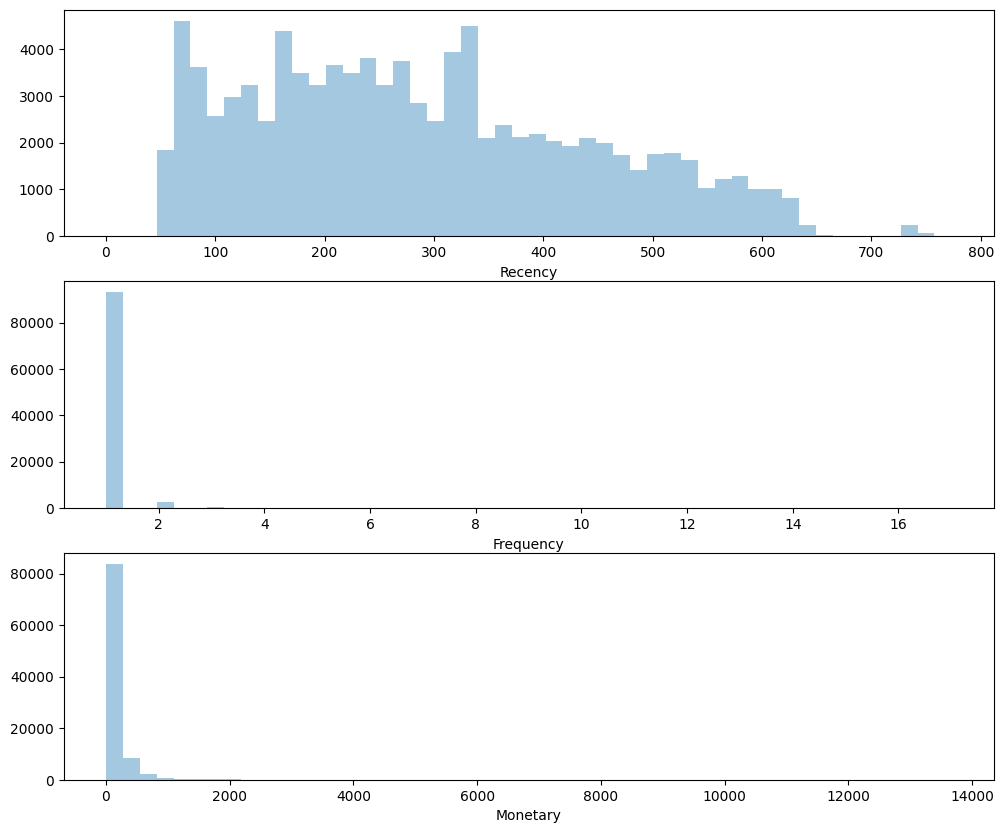

In [11]:
plt.figure(figsize=(12,10))
plt.subplot(3, 1, 1); sns.distplot(df_rfm['Recency'],kde=False)
plt.subplot(3, 1, 2); sns.distplot(df_rfm['Frequency'],kde=False)
plt.subplot(3, 1, 3); sns.distplot(df_rfm['Monetary'],kde=False)
plt.show()

### Quartiles

The next way is to find the segmentation of customers by using quartiles. In this case, scores are assigned from 1 - 4 for Recency, Frequency, and Monetary. For the value of 4 is the best value while the value of 1 is the worst. The value of the RFM will finally be calculated by combining the number of individual RFM scores.

In [12]:
quantiles = df_rfm.quantile(q=[0.25,0.5,0.75])
quantiles.to_dict()

{'Recency': {0.25: 164.0, 0.5: 269.0, 0.75: 397.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'Monetary': {0.25: 63.12, 0.5: 108.0, 0.75: 183.53}}

In [13]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [14]:
# create a table for RFM Segmentation values
rfm_segmentation = df_rfm
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles,))
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
Cust_unique_Id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90,4,1,3,413
0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,4,1,1,411
0000f46a3911fa3c0805444483337064,586,1,86.22,1,1,2,112
0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,2,1,1,211
0004aac84e0df4da2b147fca70cf8255,337,1,196.89,2,1,4,214


In [15]:
# find the number of customers in each segment
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))

Best Customers:  566
Loyal Customers:  2997
Big Spenders:  24021
Almost Lost:  449
Lost Customers:  358
Lost Cheap Customers:  6135


### Looking for active and inactive customers using the correlation matrix

<AxesSubplot:>

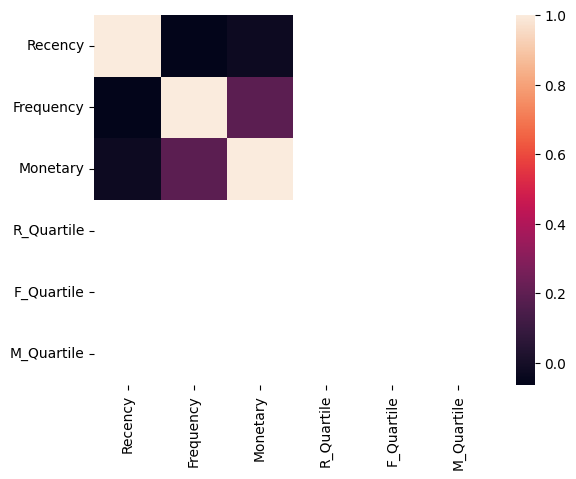

In [16]:
best_cust=rfm_segmentation[rfm_segmentation['RFMScore']=='444']
corr_matrix = best_cust.corr()
sns.heatmap(corr_matrix)

### Looking for Priority Seller

There are 4 selling factors that can be prioritized:
- Total number of sales made
- Average time it takes the seller to deliver to the operator
- Amount made in total sales
- Average review received for orders

In [17]:
# marge data sellers with orderid
seller_seg=pd.merge(order_itemdata[['order_id','seller_id','price']],orders[['order_id','order_purchase_timestamp','order_delivered_carrier_date']],on='order_id')
# marge data review score with order and order id
seller_seg=pd.merge(seller_seg,rev_data[['order_id','review_score']],on='order_id')

In [18]:
# changing dates format with datetime
seller_seg['order_purchase_timestamp']=pd.to_datetime(seller_seg['order_purchase_timestamp']).dt.date
seller_seg['order_delivered_carrier_date']=pd.to_datetime(seller_seg['order_delivered_carrier_date']).dt.date
seller_seg['days_to_del']=(seller_seg['order_delivered_carrier_date']-seller_seg['order_purchase_timestamp']).dt.days

In [19]:
# delete the unused columns
seller_seg.drop(['order_purchase_timestamp','order_delivered_carrier_date'],axis=1,inplace=True)

# removing the wrong date
seller_seg_1=seller_seg[seller_seg['days_to_del']>=0]

In [20]:
seller_seg_2=seller_seg_1.groupby('seller_id').agg({'order_id':'count','price':'sum','review_score':'mean','days_to_del':'mean'})
seller_seg_2.columns=['Tot_sales','Tot_amount','Avg_review','Avg_delivery']

In [21]:
# fill in the missing value with the average value
seller_seg_2['Avg_delivery'].fillna(seller_seg_2['Avg_delivery'].mean(),inplace=True)
quantiles = seller_seg_2.quantile(q=[0.25,0.5,0.75])
quantiles.to_dict()

{'Tot_sales': {0.25: 2.0, 0.5: 8.0, 0.75: 26.0},
 'Tot_amount': {0.25: 219.875, 0.5: 849.245, 0.75: 3475.4574999999995},
 'Avg_review': {0.25: 3.869565217391304, 0.5: 4.25, 0.75: 4.668103448275862},
 'Avg_delivery': {0.25: 1.8, 0.5: 2.6516544117647056, 0.75: 4.0}}

In [22]:
seller_seg_2['Tot_sales_Quartile'] = seller_seg_2['Tot_sales'].apply(FMScore, args=('Tot_sales',quantiles,))
seller_seg_2['Tot_amount_Quartile'] = seller_seg_2['Tot_amount'].apply(FMScore, args=('Tot_amount',quantiles,))
seller_seg_2['Avg_review_Quartile'] = seller_seg_2['Avg_review'].apply(FMScore, args=('Avg_review',quantiles,))
seller_seg_2['Avg_delivery_Quartile'] = seller_seg_2['Avg_delivery'].apply(RScore, args=('Avg_delivery',quantiles,))

In [23]:
seller_seg_2['SellerScore'] = seller_seg_2['Tot_sales_Quartile'].map(str) \
                            + seller_seg_2['Tot_amount_Quartile'].map(str) \
                            + seller_seg_2['Avg_review_Quartile'] .map(str) \
                            + seller_seg_2['Avg_delivery_Quartile'].map(str)
seller_seg_2.head()

,Tot_sales,Tot_amount,Avg_review,Avg_delivery,Tot_sales_Quartile,Tot_amount_Quartile,Avg_review_Quartile,Avg_delivery_Quartile,SellerScore
seller_id,,,,,,,,,
0015a82c2db000af6aaaf3ae2ecb0532,3,2685.00,3.666667,3.333333,2,3,1,2,2312
001cca7ae9ae17fb1caed9dfb1094831,236,24770.03,3.902542,2.614407,4,4,2,3,4423
002100f778ceb8431b7a1020ff7ab48f,56,1254.40,3.982143,4.357143,4,3,2,1,4321
003554e2dce176b5555353e4f3555ac8,1,120.00,5.000000,0.000000,1,1,4,4,1144
004c9cd9d87a3c30c522c48c4fc07416,173,20234.21,4.132948,1.670520,4,4,2,4,4424


In [24]:
# looking for sellers based on Best Sellers, highest Reviewed Sellers, Fastest delivering sellers

print("Best Sellers: ",len(seller_seg_2[seller_seg_2['SellerScore']=='4444']))
print('highest Reviewed Sellers: ',len(seller_seg_2[seller_seg_2['Avg_review_Quartile']==4]))
print("Fastest delivering sellers: ",len(seller_seg_2[seller_seg_2['Avg_delivery_Quartile']==4]))

Best Sellers:  5
highest Reviewed Sellers:  743
Fastest delivering sellers:  751


In [25]:
Fastest_delivering =seller_seg_2[seller_seg_2['Avg_delivery_Quartile']==4].reset_index()
highest_Reviewed=seller_seg_2[seller_seg_2['Avg_review_Quartile']==4].reset_index()
len(set(list(Fastest_delivering['seller_id'])).intersection(highest_Reviewed['seller_id'].tolist()))

252

<AxesSubplot:>

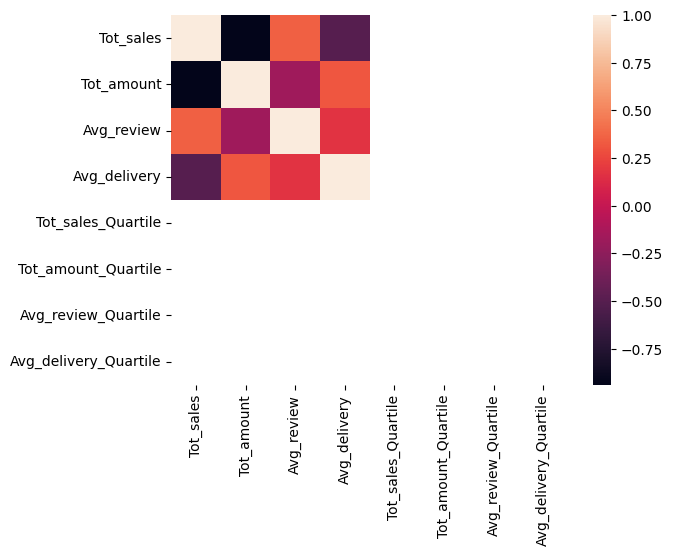

In [26]:
# visualization of best seller
best_cust=seller_seg_2[seller_seg_2['SellerScore']=='4444']
# calculate and show correlations
corr_matrix = best_cust.corr()
sns.heatmap(corr_matrix)

## Dataset Preparation

In [27]:
df1=pd.merge(data.drop(columns=['customer_zip_code_prefix']),orders[['customer_id','order_id','order_purchase_timestamp']],on='customer_id')
df2=pd.merge(df1,rev_data[['order_id','review_score']],on='order_id')
paid=pay_data[['order_id','payment_value']].groupby('order_id').sum().reset_index()
df3=pd.merge(df2,paid,on='order_id')
df3['order_purchase_timestamp']=pd.to_datetime(df3['order_purchase_timestamp']).dt.date

In [28]:
number_of_days_for_purchase=180
max_date_in_data= df3['order_purchase_timestamp'].max()
data_split_date=max_date_in_data-dt.timedelta(days=number_of_days_for_purchase)

In [29]:
df_full=df3[df3['order_purchase_timestamp']<=data_split_date]
df_last=df3[df3['order_purchase_timestamp']>data_split_date]

In [30]:
df_last_180=pd.DataFrame({'customer_unique_id':df3['customer_unique_id'].values.tolist()})
df_last_180=df_last_180.merge(df_last.groupby(['customer_unique_id'])['payment_value'].sum().reset_index(),how='outer',on='customer_unique_id')
df_last_180.fillna(0,inplace=True)

In [31]:
df_last_180['purchased']=np.where(df_last_180['payment_value']>0, 1,0)
df_last_180.head()

,customer_unique_id,payment_value,purchased
0,861eff4711a542e4b93843c6dd7febb0,0.00,0
1,290c77bc529b7ac935b93aa66c333dc3,0.00,0
2,060e732b5b29e8181a18229c7b0b2b5e,157.73,1
3,259dac757896d24d7702b9acbbff3f3c,0.00,0
4,345ecd01c38d18a9036ed96c73b8d066,252.25,1


## Feature Engineering

In [32]:
# total number of customers
tot_Amount=df_full.groupby('customer_unique_id')['payment_value'].sum().reset_index().rename(columns={'payment_value':'total_amount'})
# average of reviews given
avg_review=df_full.groupby('customer_unique_id')['review_score'].mean().reset_index().rename(columns={'review_score':'avg_review'})
# first purchase with today's purchase
min_max_date=df_full.groupby('customer_unique_id')['order_purchase_timestamp'].agg([min,max])
min_max_date['diff_first_today']=(dt.datetime.today().date()-min_max_date['min']).dt.days
# first to last month purchases
min_max_date['max']=pd.to_datetime(min_max_date['max'])
min_max_date['min']=pd.to_datetime(min_max_date['min'])
min_max_date['diff_first_last']=(min_max_date['max']-min_max_date['min']).dt.days
# latest sales
max_date=df_full['order_purchase_timestamp'].max()

min_max_date['recency']=(np.datetime64(max_date)-min_max_date['max'])/np.timedelta64(1, 'M')
# number of sales
frequency=df_full.groupby('customer_unique_id')['order_id'].count().reset_index().rename(columns={'order_id':'frequency'})

In [33]:
# engineered features merging
dataset=pd.merge(tot_Amount,avg_review,on='customer_unique_id')
dataset=pd.merge(dataset,min_max_date,on='customer_unique_id')
dataset=pd.merge(dataset,frequency,on='customer_unique_id')
dataset=pd.merge(dataset,df_full[['customer_unique_id','customer_city','customer_state']],on='customer_unique_id')
dataset.drop(['min','max'],axis=1,inplace=True)

## Encoding

In [34]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
dataset['customer_city']=encoder.fit_transform(dataset['customer_city'])
dataset['customer_state']=encoder.fit_transform(dataset['customer_state'])

In [35]:
dataset_full=dataset.merge(df_last_180[['customer_unique_id','purchased']],on='customer_unique_id')
dataset_full.drop(columns='customer_unique_id',inplace=True)

## Machine Learning models

In this Machine Learning modeling will perform binary classification to predict whether customers will buy in the next 6 months or not. Because this is a classification problem to compare models, I used metrics such as r2 score and accuracy score. 

As for the model used:
- Linear Regression
- Random Forest Classifier
- Extra Trees Classifier
- Gradient Boost Classifier
- K nearest neighbor Classifier

### Devide data into data train and data test from dataset

In [36]:
X_train,X_test,y_train,y_test=train_test_split(dataset_full.iloc[:,:-1],dataset_full.iloc[:,-1], test_size=0.2, random_state=31)

In [37]:
# calculate models gini's score 
def Gini(y_true, y_pred):
    # check and get the amount of sample 
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]
    
    # sorting the rows of prediction columns from highest to lowest score 
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:,0].argsort()][::-1,0]
    pred_order = arr[arr[:,1].argsort()][::-1,0]
    
    # looking for Lorenz curves
    L_true = np.cumsum(true_order) / np.sum(true_order)
    L_pred = np.cumsum(pred_order) / np.sum(pred_order)
    L_ones = np.linspace(1/n_samples, 1, n_samples)
    
    # looking fot Gini's coefficient (area between the curve)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)
    
    # normalize Gini's true coefficient 
    return G_pred/G_true

In [38]:
# Evaluate any Machine Learning's model by practice the data train and data test 
def evaluate(X_train, X_test, y_train, y_test):
    # Model yang digunakkan
    model_name_list = ['Linear Regression',
                      'Random Forest', 'Extra Trees',
                       'Gradient Boosted','KNeighbors']

    
    # comparison model
    model1 = LinearRegression()
    model3 = RandomForestClassifier(n_estimators=50)
    model4 = ExtraTreesClassifier(n_estimators=50)
    model6 = GradientBoostingClassifier(n_estimators=20)
    model7= KNeighborsClassifier(n_neighbors = 5)
    
    # result from dataframe
    results = pd.DataFrame(columns=['r2', 'accuracy','gini'], index = model_name_list)
    
    # Train and predict from every model
    for i, model in enumerate([model1, model3, model4, model6,model7]):
   
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Matrix
        r2 = r2_score(y_test,predictions)
        preds=np.where(predictions>0.5,1,0)
        accuracy = accuracy_score(y_test,preds)
        gini=Gini(y_test,preds)
        
        # Input result into dataframe
        model_name = model_name_list[i]
        results.loc[model_name, :] = [r2, accuracy,gini]
    
    return results

## Evaluate the Machine Learning

In [39]:
end_result=evaluate(X_train, X_test, y_train, y_test)
end_result

,r2,accuracy,gini
Linear Regression,0.047211,0.97692,0.00262
Random Forest,0.829861,0.996164,0.883196
Extra Trees,0.79918,0.995472,0.888083
Gradient Boosted,0.104676,0.979813,0.128741
KNeighbors,0.283183,0.983837,0.406596


# Conclusion

Based on the r2 value of 5 Machine Learning models, namely Linear Regression, Random Forest, Extra Trees, Gradient Boosted, and KNeighbors. It explains that the closest to a value of 1 based on the analysis of customer purchase probability predictions from Brazilian E-Commerce data is the *'Random Forest Classifier'* model that the best classifier based on the 5 models in this test.